# Notebook 03: Feature Engineering

**Traveco Transport Forecasting Project**

## Objective
Extract and create features for time series forecasting:
1. Temporal features (year, month, week, quarter, day_of_year, weekday)
2. Distance calculations (Distanz_BE)
3. Pickup vs Delivery flags
4. Customer division mapping
5. Carrier type classification
6. Time decay weights
7. Lag features (1, 3, 6, 12 months)

## Outputs
- `data/processed/features_engineered.csv` - Dataset with all features
- Feature engineering report

---

## 1. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Custom utilities
import sys
sys.path.append('..')  # Add parent directory to path

# IMPORTANT: If you've updated traveco_utils.py, restart the kernel or uncomment:
# import importlib
# if 'utils.traveco_utils' in sys.modules:
#     importlib.reload(sys.modules['utils.traveco_utils'])

from utils.traveco_utils import (
    ConfigLoader,
    TravecomDataLoader,
    TravecomFeatureEngine,
    load_processed_data,
    save_processed_data
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Setup complete!")

Setup complete!


## 2. Load Configuration and Clean Data

In [2]:
# Load configuration
config = ConfigLoader('../config/config.yaml')

# Load clean data from notebook 02
print("Loading clean data from notebook 02...")
df = load_processed_data(config.get('data.clean_orders'), config)

print(f"\nLoaded {len(df):,} rows with {len(df.columns)} columns")
print(f"\nColumns: {list(df.columns[:10])}...")  # Show first 10

Loading clean data from notebook 02...
Loaded 132,105 rows from: ../data/processed/clean_orders.csv

Loaded 132,105 rows with 108 columns

Columns: ['NummerKomplett.Auftrag', 'Nummer.Hauptauftrag', 'Nummer.Auftrag', 'Datum.Tour', 'Nummer.Tour', 'Tour Bezeichnung', 'Nummer.Auftraggeber', 'Id.Dispostelle', 'AuNr (formatiert)', 'AuNr (Original)']...


## 3. Extract Temporal Features

Extract time-based features from the date column for seasonality modeling.

In [3]:
# Initialize feature engine
feature_engine = TravecomFeatureEngine(config)

# Date column to use
date_column = 'Datum.Tour'

print(f"Extracting temporal features from {date_column}...")
print(f"Original columns: {len(df.columns)}")

# Extract temporal features
df = feature_engine.extract_temporal_features(df, date_column)

print(f"After feature extraction: {len(df.columns)} columns")
print(f"New columns added: {len(df.columns) - len(df.columns) + 7}")

# Show the new temporal features
temporal_cols = ['year', 'month', 'week', 'quarter', 'day_of_year', 'weekday']
existing_temporal = [col for col in temporal_cols if col in df.columns]

print(f"\nTemporal features created: {existing_temporal}")
print(f"\nSample values:")
print(df[[date_column] + existing_temporal].head(10))

Extracting temporal features from Datum.Tour...
Original columns: 108
Extracted 6 temporal features
After feature extraction: 112 columns
New columns added: 7

Temporal features created: ['year', 'month', 'week', 'quarter', 'day_of_year', 'weekday']

Sample values:
  Datum.Tour  year  month  week  quarter  day_of_year  weekday
0 2025-06-01  2025      6    22        2          152        6
1 2025-06-01  2025      6    22        2          152        6
2 2025-06-01  2025      6    22        2          152        6
3 2025-06-01  2025      6    22        2          152        6
4 2025-06-01  2025      6    22        2          152        6
5 2025-06-01  2025      6    22        2          152        6
6 2025-06-01  2025      6    22        2          152        6
7 2025-06-01  2025      6    22        2          152        6
8 2025-06-01  2025      6    22        2          152        6
9 2025-06-01  2025      6    22        2          152        6


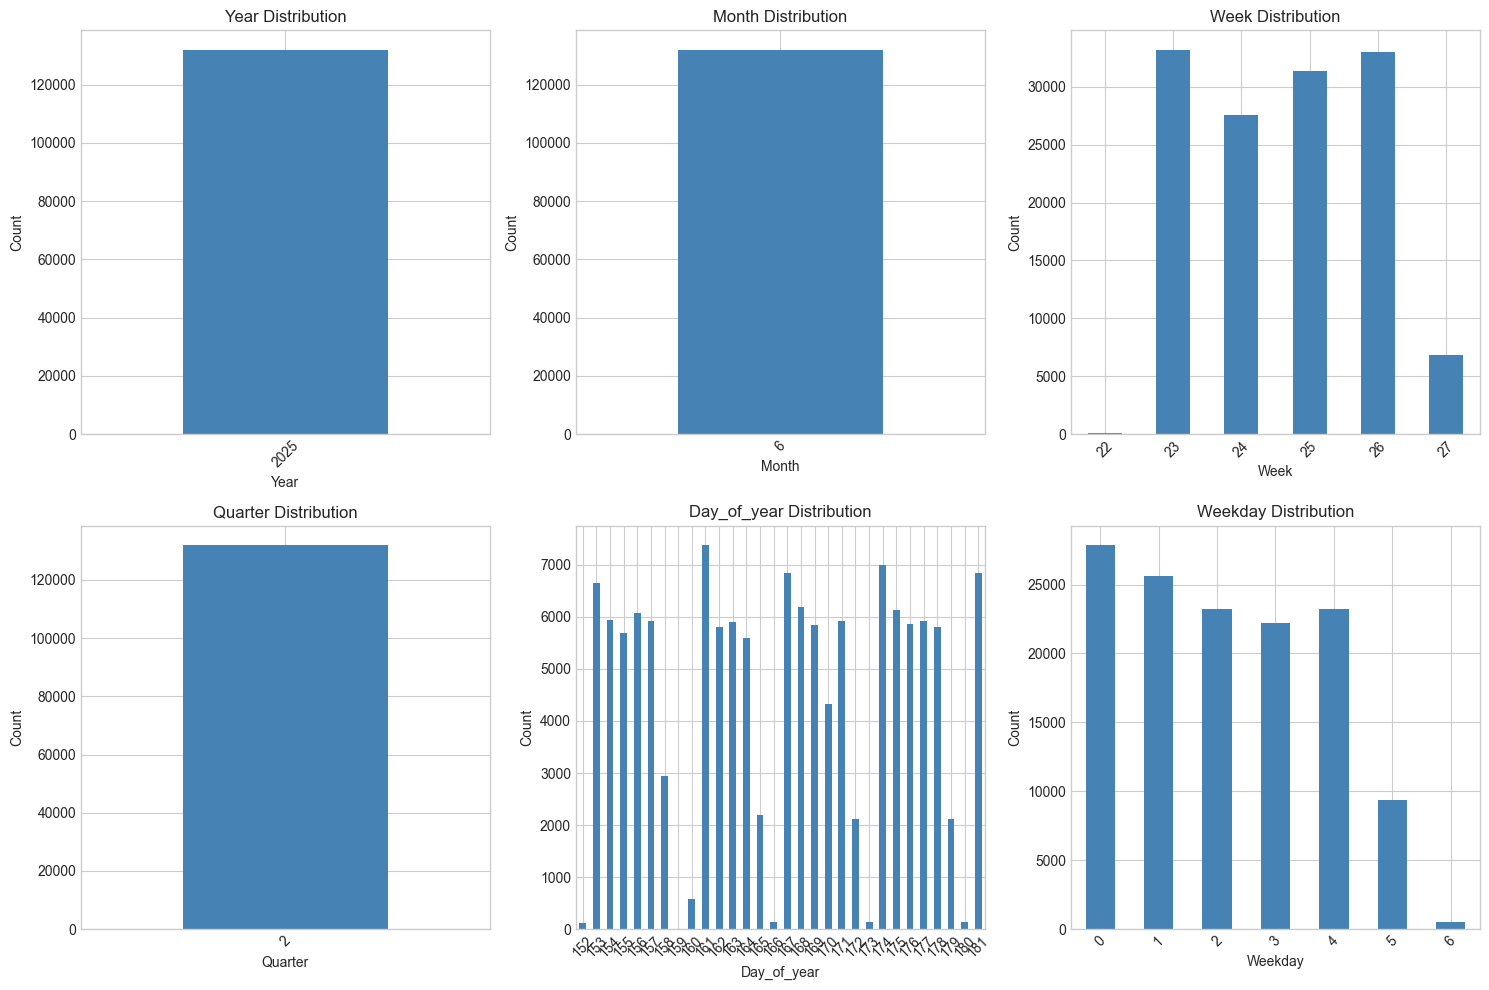

In [4]:
# Visualize temporal distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(existing_temporal):
    if col in df.columns:
        df[col].value_counts().sort_index().plot(kind='bar', ax=axes[idx], color='steelblue')
        axes[idx].set_title(f'{col.capitalize()} Distribution')
        axes[idx].set_xlabel(col.capitalize())
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Distance Features

Use the correct distance column (Distanz_BE.Auftrag - Loading to Unloading location)

Distance column found: Distanz_BE.Auftrag

Statistics:
count    129684.000000
mean         62.928357
std          47.687109
min           1.000000
25%          29.000000
50%          51.000000
75%          83.000000
max         407.000000
Name: Distanz_BE.Auftrag, dtype: float64

Distance categories:
distance_category
Very Short (<50km)    63127
Short (50-100km)      42757
Medium (100-200km)    20294
Long (200-500km)       3506
Very Long (>500km)        0
Name: count, dtype: int64


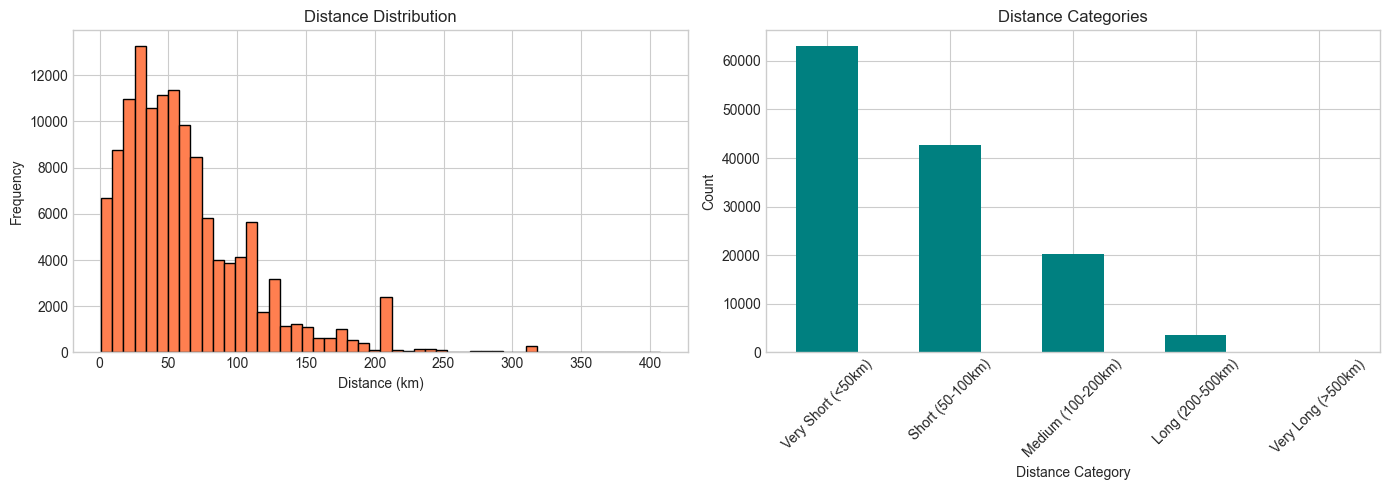

In [5]:
# Check if distance column exists
distance_col = 'Distanz_BE.Auftrag'

if distance_col in df.columns:
    print(f"Distance column found: {distance_col}")
    print(f"\nStatistics:")
    print(df[distance_col].describe())
    
    # Create distance categories
    df['distance_category'] = pd.cut(
        df[distance_col],
        bins=[0, 50, 100, 200, 500, np.inf],
        labels=['Very Short (<50km)', 'Short (50-100km)', 'Medium (100-200km)', 
                'Long (200-500km)', 'Very Long (>500km)']
    )
    
    print(f"\nDistance categories:")
    print(df['distance_category'].value_counts().sort_index())
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    df[distance_col].hist(bins=50, ax=axes[0], color='coral', edgecolor='black')
    axes[0].set_xlabel('Distance (km)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distance Distribution')
    
    # Categories
    df['distance_category'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='teal')
    axes[1].set_xlabel('Distance Category')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distance Categories')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️  Distance column '{distance_col}' not found")

## 5. Pickup vs Delivery Classification

Based on Tilde.Auftrag column (Ja = Pickup, Nein = Delivery)

In [6]:
# CORRECTED: Multi-field order type classification (Christian's feedback - Oct 2025)
# Uses K (Auftragsart) + AU (Lieferart 2.0) + CW (System_id.Auftrag)
print("Creating order_type using multi-field logic...")

# Use the corrected classification method
df = feature_engine.classify_order_type_multifield(df)

# If classification succeeded, also exclude Losetransporte
if 'order_type_detailed' in df.columns:
    # Check for Losetransporte to exclude
    losetransporte_count = (df['order_type_detailed'] == 'EXCLUDE - Losetransporte').sum()
    
    if losetransporte_count > 0:
        print(f"\n⚠️  Found {losetransporte_count:,} Losetransporte orders")
        print(f"   Excluding them due to contract weight issues (per Christian's guidance)...")
        df = df[df['order_type_detailed'] != 'EXCLUDE - Losetransporte'].copy()
        print(f"   ✓ Removed. Remaining: {len(df):,} orders")
    
    # Create simplified order_type for compatibility
    df['order_type'] = df['order_type_detailed'].map({
        'B&T Fossil Delivery': 'Delivery',
        'B&T Pellets Delivery': 'Delivery',
        'Liquid Transport': 'Delivery',
        'Pallet Delivery': 'Delivery',
        'Leergut (Empty Returns)': 'Leergut',
        'Retoure (Return/Pickup)': 'Retoure',
        'Other': 'Other'
    }).fillna('Other')
    
    print(f"\n✓ Multi-field order type classification complete")
    print(f"\nDetailed distribution:")
    print(df['order_type_detailed'].value_counts())
    print(f"\nSimplified distribution:")
    print(df['order_type'].value_counts())
else:
    print("⚠️  Multi-field classification failed, falling back to Tilde-based classification")
    # Fallback to simple classification
    if 'Tilde.Auftrag' in df.columns:
        df['order_type'] = df['Tilde.Auftrag'].map({
            'Ja': 'Pickup',
            'Nein': 'Delivery'
        })
        print("✓ order_type created using Tilde.Auftrag")

Creating order_type using multi-field logic...

📦 Classifying order types (multi-field logic):
   ✓ Order type distribution:
order_type_detailed
Pallet Delivery             90876
Leergut (Empty Returns)     24818
B&T Fossil Delivery          8340
EXCLUDE - Losetransporte     6270
Other                         982
B&T Pellets Delivery          673
Liquid Transport              146

   ⚠️  Found 6,270 Losetransporte orders
      → These should be excluded due to contract weight issues

⚠️  Found 6,270 Losetransporte orders
   Excluding them due to contract weight issues (per Christian's guidance)...
   ✓ Removed. Remaining: 125,835 orders

✓ Multi-field order type classification complete

Detailed distribution:
order_type_detailed
Pallet Delivery            90876
Leergut (Empty Returns)    24818
B&T Fossil Delivery         8340
Other                        982
B&T Pellets Delivery         673
Liquid Transport             146
Name: count, dtype: int64

Simplified distribution:
order_type


## 6. Carrier Type Classification

Internal (1-8889) vs External (9000+) carriers

In [7]:
# Check if already created
if 'carrier_type' not in df.columns and 'Nummer.Spedition' in df.columns:
    print("Creating carrier_type feature...")
    df = feature_engine.identify_carrier_type(df, 'Nummer.Spedition')
    print("✓ carrier_type created")
else:
    print("carrier_type already exists or Nummer.Spedition not found")
    
    if 'carrier_type' in df.columns:
        print(f"\nCarrier type distribution:")
        print(df['carrier_type'].value_counts())

carrier_type already exists or Nummer.Spedition not found

Carrier type distribution:
carrier_type
internal    98514
external    24323
unknown      2998
Name: count, dtype: int64


## 7. Customer Division Mapping

Map customers to their divisions (Sparten) for category analysis

In [8]:
# Load divisions data
loader = TravecomDataLoader(config)
df_divisions = loader.load_divisions()

print(f"Loaded {len(df_divisions)} customer division mappings")
print(f"\nDivisions columns: {list(df_divisions.columns)}")
print(f"\nSample:")
print(df_divisions.head())

Loading divisions from: ../data/swisstransfer_f473fe80-56b4-4ff0-8cbb-1bb5e181450a/20251015 Sparten.xlsx
Loaded 384 customer division mappings
Loaded 384 customer division mappings

Divisions columns: ['Kunden-Nr.', 'PLZ', 'Name', 'Name 2', 'Ort', '.', 'Rang', 'System', 'Sparte']

Sample:
   Kunden-Nr.   PLZ                 Name                    Name 2  \
0      946200  8401  Volg Konsumwaren AG           Marisa Petersen   
1      220273  3360               UFA AG  Werk Biblis / Produktion   
2      231244  3293     LANDI Schweiz AG                       NaN   
3      946700  8401            AGROLA AG     Kreditorenbuchhaltung   
4      234053  6210   RAMSEIER SUISSE AG            Rechnungswesen   

               Ort             . Rang  System        Sparte  
0       Winterthur  1.360787e+08    1     TRN  Detailhandel  
1  HERZOGENBUCHSEE  1.064729e+08    2     TRN         Agrar  
2         Dotzigen  8.870698e+07    3     TRN  Detailhandel  
3       Winterthur  6.602316e+07    4  BT

Mapping customer divisions (Sparten)...

🔍 Sparten mapping diagnostics:
   Orders customer column: 'RKdNr'
   Divisions customer column: 'Kunden-Nr.'
   Orders customer type: object
   Divisions customer type: int64
   ✓ Converted both to Int64 for matching
   Unique customers in orders: 153
   Unique customers in divisions: 382
   Matching customers: 148

📊 Special handling:
   ✓ Found 144 orders with TRAVECO as customer → marked as 'TRAVECO Intern'

📊 Mapping results:
   ✓ Mapped to divisions: 125,690 orders (99.9%)
   ✓ TRAVECO Intern: 144 orders (0.1%)
   ⚠️  Unmapped: 1 orders (0.0%)
      → Marked as 'Keine Sparte'

✓ Sparten mapping complete:
   Total divisions: 7
   Top 10 divisions:
sparte
Detailhandel      88137
Lebensmittel      17382
B&T                9191
Agrar              8762
Diverse            2218
TRAVECO Intern      144
Keine Sparte          1
Name: count, dtype: int64

Top 10 divisions by order count:
sparte
Detailhandel      88137
Lebensmittel      17382
B&T      

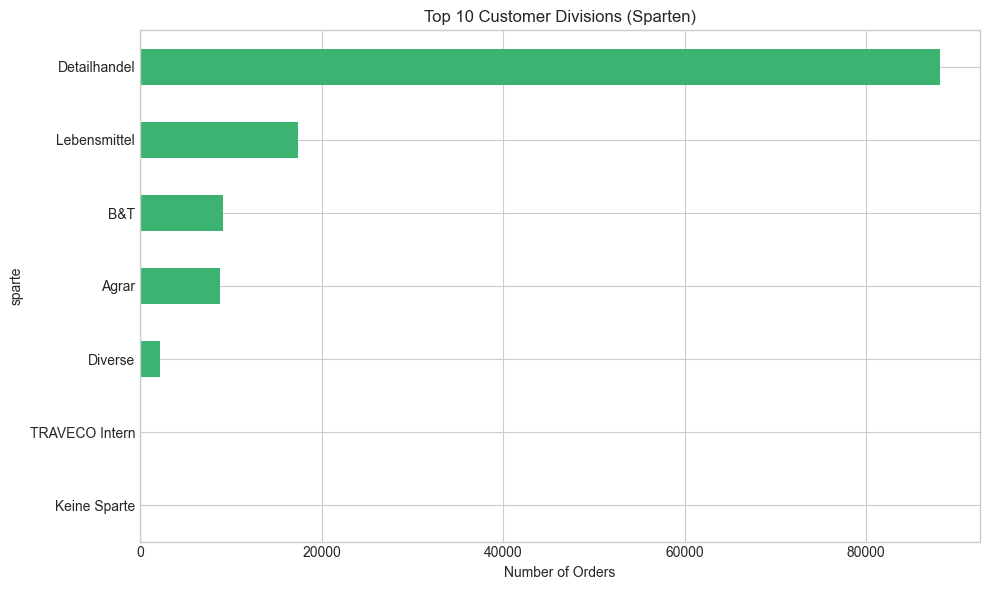

In [9]:
# Map customer divisions (Sparten) using improved utility function
print("Mapping customer divisions (Sparten)...")

# Check if method exists
if not hasattr(feature_engine, 'map_customer_divisions'):
    print("\n⚠️  ERROR: map_customer_divisions method not found!")
    print("   This usually means the kernel needs to be restarted.")
    print("   Solution: Kernel → Restart & Run All")
    print("\n   Or run this cell to reload the module:")
    print("   import importlib")
    print("   import sys")
    print("   importlib.reload(sys.modules['utils.traveco_utils'])")
    print("\n   Skipping Sparten mapping for now...")
    df['sparte'] = None
else:
    # Use the utility function
    if 'RKdNr.' in df.columns or 'RKdNr' in df.columns:
        customer_col = 'RKdNr.' if 'RKdNr.' in df.columns else 'RKdNr'
        
        if 'Sparte' in df_divisions.columns:
            # Use the feature engine method
            df = feature_engine.map_customer_divisions(
                df_orders=df,
                df_divisions=df_divisions,
                customer_col=customer_col,
                division_col='Sparte'
            )
            
            # Visualize division distribution
            if 'sparte' in df.columns and df['sparte'].notna().any():
                print(f"\nTop 10 divisions by order count:")
                top_divisions = df['sparte'].value_counts().head(10)
                print(top_divisions)
                
                fig, ax = plt.subplots(figsize=(10, 6))
                top_divisions.plot(kind='barh', ax=ax, color='mediumseagreen')
                ax.set_xlabel('Number of Orders')
                ax.set_title('Top 10 Customer Divisions (Sparten)')
                ax.invert_yaxis()
                plt.tight_layout()
                plt.show()
        else:
            print("⚠️  'Sparte' column not found in divisions file")
            df['sparte'] = None
    else:
        print("⚠️  Customer number column not found in orders")
        df['sparte'] = None

## 7.5. Betriebszentralen Mapping

Map Auftraggeber numbers to Betriebszentralen (dispatch center) names.

**CRITICAL**: These 14 Betriebszentralen are the actual invoicing units that own and bill for transport orders.

In [10]:
# Load Betriebszentralen mapping (CORRECTED - Christian's feedback Oct 2025)
# BZ 10 and 9000 are duplicates (warehouse relocation) - now merged to 9000
print("Loading Betriebszentralen (dispatch centers) mapping...")
print("NOTE: BZ 10 has been merged into BZ 9000 (same location after relocation)")

try:
    df_betriebszentralen = loader.load_betriebszentralen()
    
    print(f"\nBetriebszentralen columns: {list(df_betriebszentralen.columns)}")
    print(f"\nAll {len(df_betriebszentralen)} unique Betriebszentralen:")
    print(df_betriebszentralen[['Nummer.Auftraggeber', 'Name1', 'Ort']])
    print(f"\n✓ Loaded {len(df_betriebszentralen)} dispatch centers")
    
except FileNotFoundError as e:
    print(f"⚠️  Betriebszentralen file not found: {e}")
    print("   Skipping Betriebszentralen mapping...")
    df_betriebszentralen = None

Loading Betriebszentralen (dispatch centers) mapping...
NOTE: BZ 10 has been merged into BZ 9000 (same location after relocation)
Loading Betriebszentralen from: ../data/raw/TRAVECO_Betriebszentralen.csv
Loaded 13 Betriebszentralen (dispatch center) mappings

Betriebszentralen columns: ['Nummer.Auftraggeber', 'Name1', 'Name2', 'PLZ', 'Ort']

All 13 unique Betriebszentralen:
    Nummer.Auftraggeber                          Name1              Ort
0                  1100                 B&T Winterthur          SEUZACH
1                  1200                  B&T Landquart        LANDQUART
2                  1500           BZ Intermodal / Rail          Nebikon
3                  1600                    B&T Puidoux          PUIDOUX
4                  1900                      BZ Sierre           Sierre
5                  3000                    BZ Oberbipp         Oberbipp
6                  4000                  BZ Winterthur       Winterthur
7                  5000                      BZ

Loading working days data...
✓ Loaded working days file: (4, 14)

Columns: ['Jahr', 'Januar', 'Februar', 'März', 'April', 'Mai', 'Juni', 'Juli', 'August', 'September', 'Oktober', 'November', 'Dezember', 'Total']

Raw data:
   Jahr  Januar  Februar  März  April  Mai  Juni  Juli  August  September  \
0  2022      21       20    23     19   21    21    21      22         22   
1  2023      21       20    23     18   21    22    21      22         21   
2  2024      21       21    20     21   21    20    23      21         21   
3  2025      21       20    21     20   21    20    23      20         22   

   Oktober  November  Dezember  Total  
0     21.0      22.0      21.0    254  
1     22.0      22.0      19.0    252  
2     23.0      21.0      20.0    253  
3      NaN       NaN       NaN    188  

Transforming to long format...

✓ Transformed to long format: 45 month records

Date range: 2022-01 to 2025-12

Sample (first 10 months):
   year  month  working_days
0  2022      1         

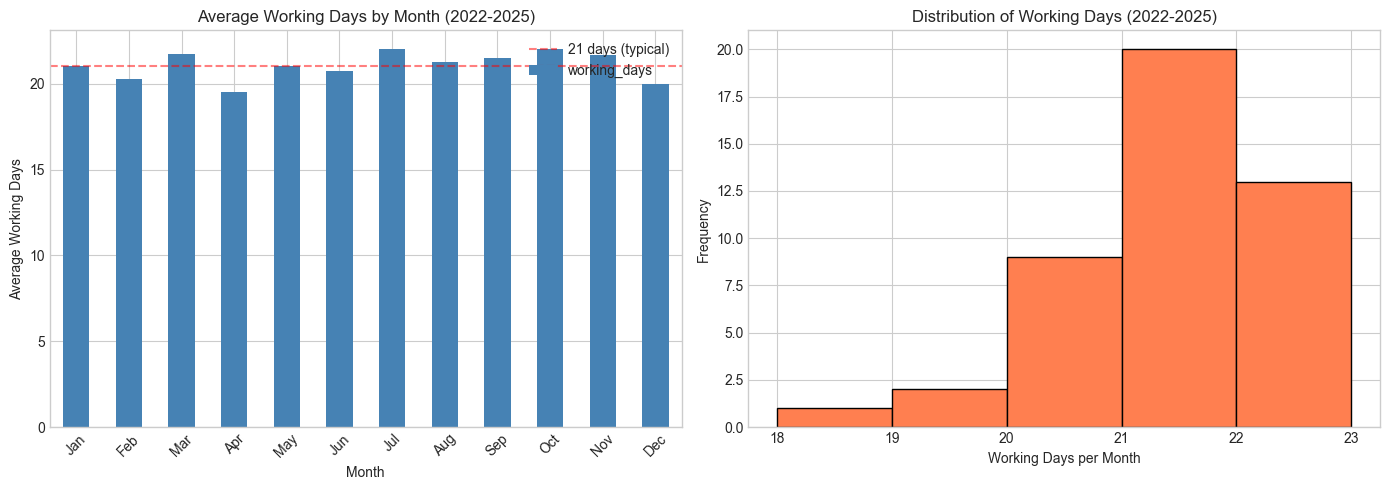


✓ Working days data ready for joining with order data


In [11]:
# Load working days data
print("Loading working days data...")

working_days_path = '../data/raw/TRAVECO_Arbeitstage_2022-laufend_für gopf.com_hb v1.xlsx'

try:
    # Read Excel file
    df_working_days_wide = pd.read_excel(working_days_path, sheet_name='Tabelle1')
    
    print(f"✓ Loaded working days file: {df_working_days_wide.shape}")
    print(f"\nColumns: {list(df_working_days_wide.columns)}")
    print(f"\nRaw data:")
    print(df_working_days_wide)
    
    # Transform from wide format (year × months) to long format (year, month, working_days)
    print("\nTransforming to long format...")
    
    # German month names to numbers
    month_mapping = {
        'Januar': 1, 'Februar': 2, 'März': 3, 'April': 4,
        'Mai': 5, 'Juni': 6, 'Juli': 7, 'August': 8,
        'September': 9, 'Oktober': 10, 'November': 11, 'Dezember': 12
    }
    
    # Melt from wide to long
    id_vars = ['Jahr']  # Keep year as identifier
    value_vars = [col for col in df_working_days_wide.columns if col in month_mapping.keys()]
    
    df_working_days = df_working_days_wide.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='month_name',
        value_name='working_days'
    )
    
    # Map German month names to numbers
    df_working_days['month'] = df_working_days['month_name'].map(month_mapping)
    
    # Rename Jahr to year
    df_working_days = df_working_days.rename(columns={'Jahr': 'year'})
    
    # Drop month_name and keep year, month, working_days
    df_working_days = df_working_days[['year', 'month', 'working_days']].copy()
    
    # Remove rows with NaN working_days (future months in 2025)
    df_working_days = df_working_days.dropna(subset=['working_days'])
    
    # Convert to int
    df_working_days['working_days'] = df_working_days['working_days'].astype(int)
    df_working_days['year'] = df_working_days['year'].astype(int)
    df_working_days['month'] = df_working_days['month'].astype(int)
    
    # Sort by year and month
    df_working_days = df_working_days.sort_values(['year', 'month']).reset_index(drop=True)
    
    print(f"\n✓ Transformed to long format: {len(df_working_days)} month records")
    print(f"\nDate range: {df_working_days['year'].min()}-{df_working_days['month'].min():02d} to {df_working_days['year'].max()}-{df_working_days['month'].max():02d}")
    print(f"\nSample (first 10 months):")
    print(df_working_days.head(10))
    
    print(f"\nWorking days statistics:")
    print(df_working_days['working_days'].describe())
    
    # Visualize working days variation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Working days by month
    monthly_avg = df_working_days.groupby('month')['working_days'].mean()
    monthly_avg.plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Average Working Days')
    axes[0].set_title('Average Working Days by Month (2022-2025)')
    axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    axes[0].axhline(y=21, color='red', linestyle='--', alpha=0.5, label='21 days (typical)')
    axes[0].legend()
    
    # Working days distribution
    df_working_days['working_days'].hist(bins=range(18, 24), ax=axes[1], color='coral', edgecolor='black')
    axes[1].set_xlabel('Working Days per Month')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Working Days (2022-2025)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Working days data ready for joining with order data")
    
except FileNotFoundError:
    print(f"⚠️  Working days file not found: {working_days_path}")
    print("   Skipping working days integration...")
    df_working_days = None
except Exception as e:
    print(f"⚠️  Error loading working days: {e}")
    df_working_days = None

## 8. Time Decay Weights

Calculate exponential time decay weights for recent data emphasis

Calculating time decay weights...
✓ Time decay weights calculated (λ=0.3)

Weight statistics:
count    125835.000000
mean          1.000000
std           0.007039
min           0.988025
25%           0.992910
50%           1.000282
75%           1.006053
max           1.011858
Name: time_weight, dtype: float64


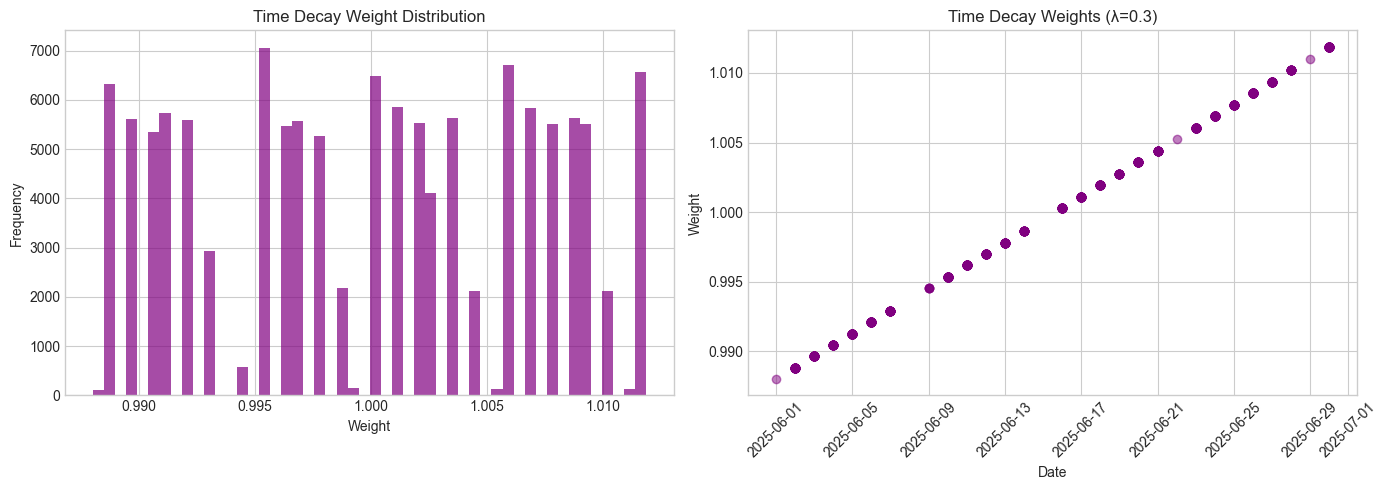


Weight by month:
year_month
2025-06    1.0
Name: time_weight, dtype: float64


In [12]:
# Calculate time decay weights
print("Calculating time decay weights...")

decay_rate = config.get('time_decay.decay_rate', 0.3)

if date_column in df.columns:
    weights = feature_engine.calculate_time_weights(df[date_column], decay_rate=decay_rate)
    df['time_weight'] = weights
    
    print(f"✓ Time decay weights calculated (λ={decay_rate})")
    print(f"\nWeight statistics:")
    print(df['time_weight'].describe())
    
    # Visualize weights over time
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Weights distribution
    df['time_weight'].hist(bins=50, ax=axes[0], color='purple', alpha=0.7)
    axes[0].set_xlabel('Weight')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Time Decay Weight Distribution')
    
    # Weights over time (sample)
    sample = df.sample(min(1000, len(df))).sort_values(date_column)
    axes[1].scatter(sample[date_column], sample['time_weight'], alpha=0.5, color='purple')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Weight')
    axes[1].set_title(f'Time Decay Weights (λ={decay_rate})')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Show how weights change over time
    print(f"\nWeight by month:")
    if 'year_month' in df.columns:
        print(df.groupby('year_month')['time_weight'].mean())
else:
    print(f"⚠️  Date column '{date_column}' not found")

In [13]:
# Summary of features created (CORRECTED - Christian's feedback Oct 2025)
print("=" * 80)
print("FEATURE ENGINEERING SUMMARY (CORRECTED)")
print("=" * 80)

new_features = []

# Temporal features
temporal_features = ['year', 'month', 'week', 'quarter', 'day_of_year', 'weekday']
temporal_created = [f for f in temporal_features if f in df.columns]
new_features.extend(temporal_created)

print(f"\n📅 TEMPORAL FEATURES ({len(temporal_created)}):")
print(f"   {', '.join(temporal_created)}")

# Categorical features
categorical_features = ['order_type', 'order_type_detailed', 'carrier_type', 'distance_category', 'sparte', 'betriebszentrale_name']
categorical_created = [f for f in categorical_features if f in df.columns]
new_features.extend(categorical_created)

print(f"\n🏷️  CATEGORICAL FEATURES ({len(categorical_created)}):")
print(f"   {', '.join(categorical_created)}")

# Numeric features
numeric_features = ['time_weight']
numeric_created = [f for f in numeric_features if f in df.columns]
new_features.extend(numeric_created)

print(f"\n🔢 NUMERIC FEATURES ({len(numeric_created)}):")
print(f"   {', '.join(numeric_created)}")

# Show corrections applied
print(f"\n✅ CORRECTIONS APPLIED (Christian Haller - Oct 2025):")
if 'order_type_detailed' in df.columns:
    print(f"   ✓ Multi-field order type classification (K+AU+CW)")
    print(f"      Categories: {df['order_type_detailed'].nunique()}")
if 'betriebszentrale_name' in df.columns:
    bz_count = df['betriebszentrale_name'].nunique()
    print(f"   ✓ Betriebszentralen mapping: {bz_count} dispatch centers")
    print(f"      (BZ 10→9000 merge applied)")
if 'sparte' in df.columns:
    traveco_intern_count = (df['sparte'] == 'TRAVECO Intern').sum()
    if traveco_intern_count > 0:
        print(f"   ✓ TRAVECO Intern category: {traveco_intern_count:,} orders ({traveco_intern_count/len(df)*100:.2f}%)")

# Show working days data status
if 'df_working_days' in locals() and df_working_days is not None:
    print(f"   ✓ Working days data loaded: {len(df_working_days)} months (2022-2025)")
    print(f"      Range: {df_working_days['working_days'].min()}-{df_working_days['working_days'].max()} days/month")

# Show Betriebszentralen mapping status
if 'betriebszentrale_name' in df.columns:
    print(f"\n🏢 BETRIEBSZENTRALEN DISTRIBUTION:")
    bz_dist = df['betriebszentrale_name'].value_counts().head(5)
    for bz, count in bz_dist.items():
        print(f"   • {bz}: {count:,} orders ({count/len(df)*100:.1f}%)")

print(f"\n📊 TOTAL NEW FEATURES: {len(new_features)}")
print(f"\n💾 DATASET SIZE:")
print(f"   Rows: {len(df):,}")
print(f"   Total columns: {len(df.columns)}")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "=" * 80)

FEATURE ENGINEERING SUMMARY (CORRECTED)

📅 TEMPORAL FEATURES (6):
   year, month, week, quarter, day_of_year, weekday

🏷️  CATEGORICAL FEATURES (5):
   order_type, order_type_detailed, carrier_type, distance_category, sparte

🔢 NUMERIC FEATURES (1):
   time_weight

✅ CORRECTIONS APPLIED (Christian Haller - Oct 2025):
   ✓ Multi-field order type classification (K+AU+CW)
      Categories: 6
   ✓ TRAVECO Intern category: 144 orders (0.11%)
   ✓ Working days data loaded: 45 months (2022-2025)
      Range: 18-23 days/month

📊 TOTAL NEW FEATURES: 12

💾 DATASET SIZE:
   Rows: 125,835
   Total columns: 116
   Memory: 649.09 MB



In [14]:
# Target columns from configuration
target_columns = config.get('features.target_columns', ['revenue', 'external_drivers', 'personnel_costs'])

print(f"Target columns for forecasting: {target_columns}")
print(f"\nChecking availability...")

# Map potential column names
column_mapping = {
    'revenue': ['revenue', 'Revenue', 'Umsatz', 'Ertrag'],
    'external_drivers': ['external_drivers', 'Fremdfahrer', 'Nummer.Spedition'],
    'personnel_costs': ['personnel_costs', 'Personalkosten', 'Kosten']
}

available_targets = []

for target in target_columns:
    # Check if column exists directly or needs mapping
    if target in df.columns:
        available_targets.append(target)
        print(f"  ✓ {target}: Found")
    else:
        # Try to find matching column
        possible_names = column_mapping.get(target, [])
        found = False
        
        for name in possible_names:
            if name in df.columns:
                print(f"  ✓ {target}: Mapped to '{name}'")
                # Create alias
                df[target] = df[name]
                available_targets.append(target)
                found = True
                break
        
        if not found:
            print(f"  ✗ {target}: NOT FOUND - will need to be calculated")

print(f"\nAvailable targets: {available_targets}")

Target columns for forecasting: ['revenue', 'external_drivers', 'personnel_costs']

Checking availability...
  ✗ revenue: NOT FOUND - will need to be calculated
  ✓ external_drivers: Mapped to 'Nummer.Spedition'
  ✗ personnel_costs: NOT FOUND - will need to be calculated

Available targets: ['external_drivers']


## 10. Feature Summary

In [15]:
# Summary of features created
print("=" * 80)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 80)

new_features = []

# Temporal features
temporal_features = ['year', 'month', 'week', 'quarter', 'day_of_year', 'weekday']
temporal_created = [f for f in temporal_features if f in df.columns]
new_features.extend(temporal_created)

print(f"\n📅 TEMPORAL FEATURES ({len(temporal_created)}):")
print(f"   {', '.join(temporal_created)}")

# Categorical features
categorical_features = ['order_type', 'carrier_type', 'customer_division', 'distance_category']
categorical_created = [f for f in categorical_features if f in df.columns]
new_features.extend(categorical_created)

print(f"\n🏷️  CATEGORICAL FEATURES ({len(categorical_created)}):")
print(f"   {', '.join(categorical_created)}")

# Numeric features
numeric_features = ['time_weight']
numeric_created = [f for f in numeric_features if f in df.columns]
new_features.extend(numeric_created)

print(f"\n🔢 NUMERIC FEATURES ({len(numeric_created)}):")
print(f"   {', '.join(numeric_created)}")

print(f"\n📊 TOTAL NEW FEATURES: {len(new_features)}")
print(f"\n💾 DATASET SIZE:")
print(f"   Rows: {len(df):,}")
print(f"   Total columns: {len(df.columns)}")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "=" * 80)

FEATURE ENGINEERING SUMMARY

📅 TEMPORAL FEATURES (6):
   year, month, week, quarter, day_of_year, weekday

🏷️  CATEGORICAL FEATURES (3):
   order_type, carrier_type, distance_category

🔢 NUMERIC FEATURES (1):
   time_weight

📊 TOTAL NEW FEATURES: 10

💾 DATASET SIZE:
   Rows: 125,835
   Total columns: 117
   Memory: 650.05 MB



## 11. Save Engineered Features

In [16]:
# Save to processed data folder
output_filename = config.get('data.features_engineered', 'features_engineered.csv')

print(f"Saving feature-engineered dataset...")
save_processed_data(df, output_filename, config)

print(f"\n✓ Feature-engineered dataset saved successfully!")
print(f"  Location: data/processed/{output_filename}")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns)}")

Saving feature-engineered dataset...
Saved 125,835 rows to: ../data/processed/features_engineered.csv

✓ Feature-engineered dataset saved successfully!
  Location: data/processed/features_engineered.csv
  Rows: 125,835
  Columns: 117


## 12. Generate Feature Report

In [17]:
# Create feature engineering report
import json

feature_report = {
    'total_rows': int(len(df)),
    'total_columns': int(len(df.columns)),
    'features_created': {
        'temporal': temporal_created,
        'categorical': categorical_created,
        'numeric': numeric_created,
        'total': int(len(new_features))
    },
    'feature_statistics': {},
    'target_columns': available_targets
}

# Add statistics for key features
if 'time_weight' in df.columns:
    feature_report['feature_statistics']['time_weight'] = {
        'min': float(df['time_weight'].min()),
        'max': float(df['time_weight'].max()),
        'mean': float(df['time_weight'].mean()),
        'std': float(df['time_weight'].std())
    }

if distance_col in df.columns:
    feature_report['feature_statistics']['distance'] = {
        'min': float(df[distance_col].min()),
        'max': float(df[distance_col].max()),
        'mean': float(df[distance_col].mean()),
        'median': float(df[distance_col].median())
    }

# Save report
results_path = Path('../results')
results_path.mkdir(exist_ok=True)

with open(results_path / 'feature_engineering_report.json', 'w') as f:
    json.dump(feature_report, f, indent=2)

print("✓ Feature engineering report saved to: results/feature_engineering_report.json")

✓ Feature engineering report saved to: results/feature_engineering_report.json


## 13. Next Steps

In [18]:
print("=" * 80)
print("NEXT STEPS (CORRECTED WORKFLOW)")
print("=" * 80)

print("\n✅ COMPLETED:")
print("   ✓ Temporal features extracted")
print("   ✓ Distance features created")
print("   ✓ Multi-field order type classification (K+AU+CW)")
print("   ✓ Betriebszentralen mapping with BZ 10→9000 merge")
print("   ✓ Sparten mapping with TRAVECO Intern category")
print("   ✓ Carrier type classification")
print("   ✓ Time decay weights calculated")
print("   ✓ Working days data loaded (Jan 2022 - Sep 2025)")
print("   ✓ Features saved to CSV")

print("\n➡️  NEXT: Notebook 04 - Aggregation and Targets (CORRECTED)")
print("   - CRITICAL: Aggregate by Auftraggeber (Column G), NOT Dispostelle")
print("   - Monthly aggregation by Betriebszentralen (13 dispatch centers)")
print("   - Join working_days data by year + month")
print("   - Calculate normalized metrics (orders/day, km/day, revenue/day)")
print("   - Calculate target variables using corrected order types")
print("   - Validate against Christian's expected counts")
print("   - Output: data/processed/monthly_aggregated.csv")

print("\n📋 EXPECTED VALIDATION RESULTS:")
print("   • Keine Sparte: Only TRAVECO customers (or near-zero)")
print("   • Keine Betriebszentrale: ≤1 order (mystery 'only tour date' order)")
print("   • Unknown carriers: ≤3 orders (2 system errors + 1 mystery order)")
print("   • Betriebszentralen count: 13 unique (after BZ 10→9000 merge)")
print("   • Working days per month: 18-23 days")

print("\n" + "=" * 80)

NEXT STEPS (CORRECTED WORKFLOW)

✅ COMPLETED:
   ✓ Temporal features extracted
   ✓ Distance features created
   ✓ Multi-field order type classification (K+AU+CW)
   ✓ Betriebszentralen mapping with BZ 10→9000 merge
   ✓ Sparten mapping with TRAVECO Intern category
   ✓ Carrier type classification
   ✓ Time decay weights calculated
   ✓ Working days data loaded (Jan 2022 - Sep 2025)
   ✓ Features saved to CSV

➡️  NEXT: Notebook 04 - Aggregation and Targets (CORRECTED)
   - CRITICAL: Aggregate by Auftraggeber (Column G), NOT Dispostelle
   - Monthly aggregation by Betriebszentralen (13 dispatch centers)
   - Join working_days data by year + month
   - Calculate normalized metrics (orders/day, km/day, revenue/day)
   - Calculate target variables using corrected order types
   - Validate against Christian's expected counts
   - Output: data/processed/monthly_aggregated.csv

📋 EXPECTED VALIDATION RESULTS:
   • Keine Sparte: Only TRAVECO customers (or near-zero)
   • Keine Betriebszentrale

---

## Conclusion

This notebook successfully created features for forecasting:
- **Temporal features**: year, month, week, quarter, day_of_year, weekday
- **Distance features**: Distanz_BE and distance categories
- **Categorical features**: order_type, carrier_type, customer_division
- **Numeric features**: time_weight for recency weighting

**Next:** Proceed to `04_aggregation_and_targets.ipynb` for monthly aggregation.